# Mini-Projet : Détection et classification de panneaux de signalisation (GTSDB database)

On commence par importer les modules nécessaires :

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import seaborn as sns

## Partie 1 - Exploration et préparation de la base

### 1. Visualisation et inspection rapide

#### Question 1.a

On commence par charger les annotations :

In [2]:
col_names = ['Filename', 'x1', 'y1', 'x2', 'y2', 'ClassId']
DATA_PATH = 'TrainIJCNN2013' 
gt_file = os.path.join(DATA_PATH, 'gt.txt')
df = pd.read_csv(gt_file, sep=';', names=col_names)
print(f"Annotations chargées : {len(df)} panneaux trouvés.")

Annotations chargées : 852 panneaux trouvés.


In [3]:
df.head()

,Filename,x1,y1,x2,y2,ClassId
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


On définit une fonction d'affichage :

In [4]:
def visualize_samples(df, num_samples=5):
    # Sélection de quelques images uniques aléatoirement
    unique_images = df['Filename'].unique()
    # On prend les 5 premières images
    sample_files = unique_images[:num_samples] 
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    
    for ax, img_file in zip(axes, sample_files):
        img_path = os.path.join(DATA_PATH, img_file)
        
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            
            # Récupération de toutes les annotations pour cette image précise
            img_annotations = df[df['Filename'] == img_file]
            
            for _, row in img_annotations.iterrows():
                # Création du rectangle
                width = row['x2'] - row['x1']
                height = row['y2'] - row['y1']
                
                rect = patches.Rectangle(
                    (row['x1'], row['y1']), 
                    width, 
                    height, 
                    linewidth=2, 
                    edgecolor='r', 
                    facecolor='none'
                )
                ax.add_patch(rect)
                
            ax.set_title(f"Fichier: {img_file}")
            ax.axis('off')
            
        except FileNotFoundError:
            ax.text(0.5, 0.5, "Image introuvable", ha='center')
            ax.set_title(img_file)

    plt.show()

On exécute la visualisation :

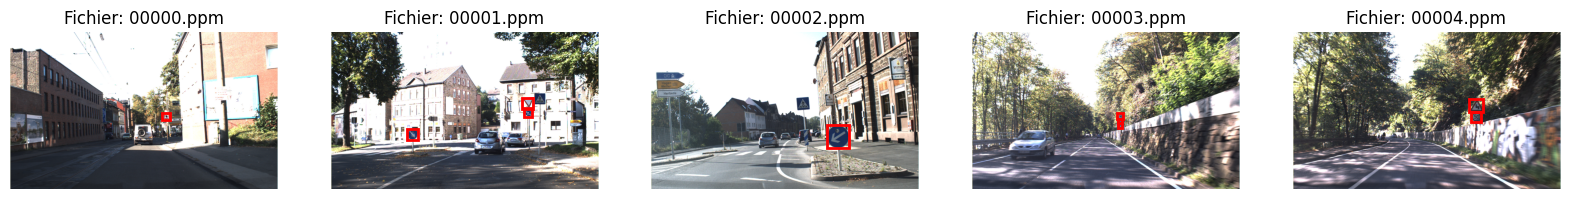

In [5]:
visualize_samples(df, num_samples=5)

#### Question 1.b

On peut représenter les dimensions des panneaux :

            Width      Height
count  852.000000  852.000000
mean    43.395540   42.751174
std     22.349686   21.503074
min     16.000000   16.000000
25%     27.000000   27.000000
50%     38.000000   37.000000
75%     53.000000   52.000000
max    127.000000  128.000000


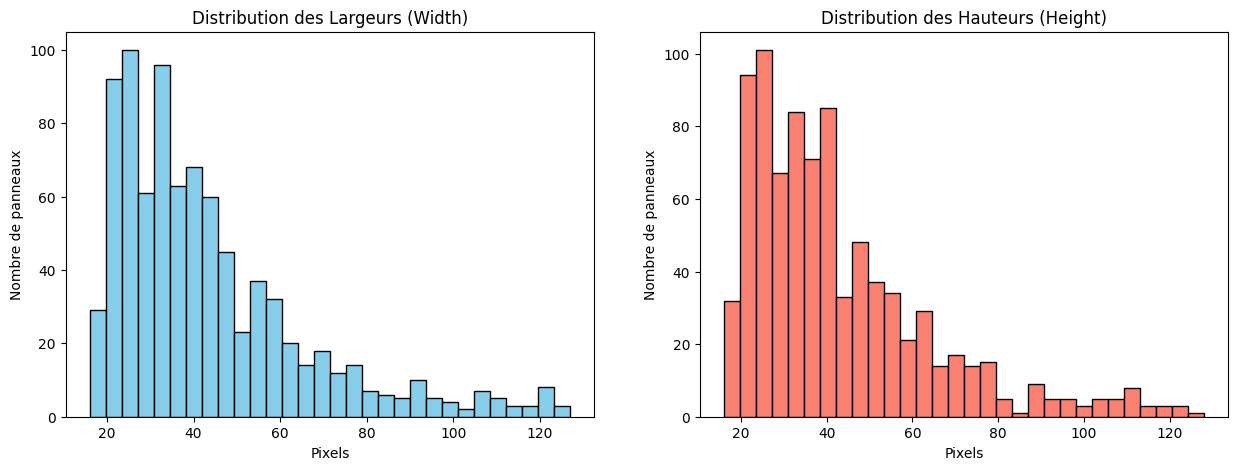

In [6]:
# Calcul des largeurs et hauteurs des panneaux
df['Width'] = df['x2'] - df['x1']
df['Height'] = df['y2'] - df['y1']

# Affichage des statistiques descriptives
print(df[['Width', 'Height']].describe())

# Visualisation de la distribution des tailles
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Width'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des Largeurs (Width)')
plt.xlabel('Pixels')
plt.ylabel('Nombre de panneaux')

plt.subplot(1, 2, 2)
plt.hist(df['Height'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution des Hauteurs (Height)')
plt.xlabel('Pixels')
plt.ylabel('Nombre de panneaux')

plt.show()

In [7]:
df.head()

,Filename,x1,y1,x2,y2,ClassId,Width,Height
0,00000.ppm,774,411,815,446,11,41,35
1,00001.ppm,983,388,1024,432,40,41,44
2,00001.ppm,386,494,442,552,38,56,58
3,00001.ppm,973,335,1031,390,13,58,55
4,00002.ppm,892,476,1006,592,39,114,116


On remarque qu'il y a une très grande variabilité dans la taille des cadres autour des panneaux. Ces derniers varient de moins de 20 pixels de côté à plus de 120 pixels de côté. Ainsi, le redimensionnement vers une taille fixe sera destructeur pour les grands panneaux et créera du flou pour les petits panneaux (upscaling).

Les conditions d'éclairage changent drastiquement. L'image `00000.ppm` présente un fort contraste avec des ombres marquées, tandis que l'image `00004.ppm` est prise dans une zone ombragée où les panneaux sont sombres et peu contrastés par rapport au fond.

Les fonds sont complexes. Sur l'image `00004.ppm`, le panneau est entouré de feuillage, ce qui rend les contours moins nets.

Les panneaux ne sont pas toujours parfaitement de face. Il y a des rotations légères ou des perspectives qui déforment le ratio hauteur/largeur du panneau.

### 2. Extraction des imagettes de panneaux

On définit une fonction qui extraie et redimensionne les imagettes à partir de chaque image :

In [8]:
IMG_SIZE = 32

def extract_and_resize_signs(df, data_path, target_size=(IMG_SIZE, IMG_SIZE)):
    X = [] # Stockage des pixels des images
    y = [] # Stockage des classes (labels)
    
    for index, row in df.iterrows():
        try:
            img_path = os.path.join(data_path, row['Filename'])
            img = Image.open(img_path)
            
            # Extraction
            region = img.crop((row['x1'], row['y1'], row['x2'], row['y2']))
            
            # Redimensionnement
            region = region.resize(target_size, Image.Resampling.LANCZOS)
            
            # Conversion en tableau numpy et stockage
            X.append(np.array(region))
            y.append(row['ClassId'])
            
        except Exception as e:
            print(f"Erreur sur l'image {row['Filename']} index {index}: {e}")
            
    return np.array(X), np.array(y)

On exécute l'extraction et le redimensionnement des images :

In [9]:
X, y = extract_and_resize_signs(df, DATA_PATH)

print(f"\nExtraction terminée.")
print(f"Dimension de X (Images) : {X.shape}")
print(f"Dimension de y (Labels) : {y.shape}")


Extraction terminée.
Dimension de X (Images) : (852, 32, 32, 3)
Dimension de y (Labels) : (852,)


On affiche quelques imagettes extraites pour vérifier que le redimensionnement est bon :

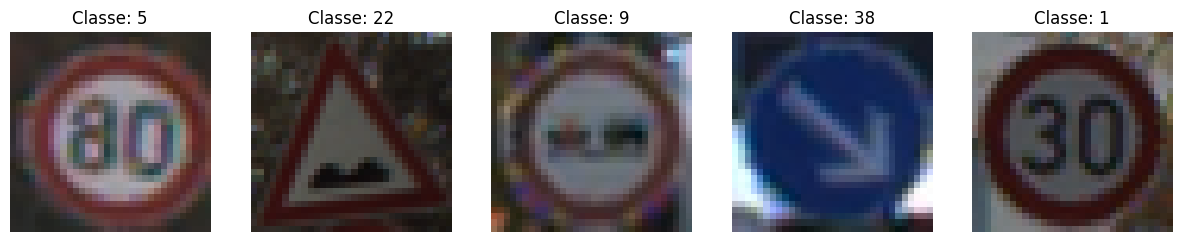

In [10]:
plt.figure(figsize=(15, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # On prend un index aléatoire
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.title(f"Classe: {y[idx]}")
    plt.axis("off")
plt.show()

### 3. Filtrage des classes

#### Question 3.a

On calcule le nombre de pixels par classe :

In [11]:
unique, counts = np.unique(y, return_counts=True)
print(f"Nombre total de classes au départ : {len(unique)}")

Nombre total de classes au départ : 43


On peut visualiser la distribution des classes :

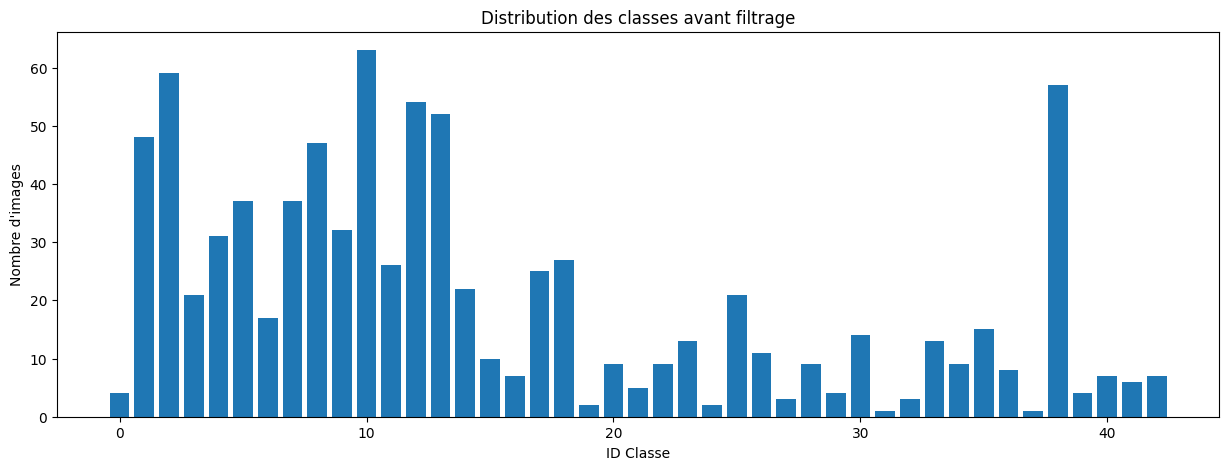

In [12]:
# Création d'un dictionnaire pour visualiser
class_counts = dict(zip(unique, counts))

# Visualisation
plt.figure(figsize=(15, 5))
plt.bar(unique, counts)
plt.title("Distribution des classes avant filtrage")
plt.xlabel("ID Classe")
plt.ylabel("Nombre d'images")
plt.show()

#### Question 3.b

On identifie les les classes les plus fréquentes (avec plus de 20 imagettes) :

In [13]:
valid_classes = [cls for cls, count in class_counts.items() if count > 20]

On créé des masques booléens pour filtrer `X` et `y` :

In [14]:
mask = np.isin(y, valid_classes)

X_filtered = X[mask]
y_filtered = y[mask]

On réencode les labels en gardant les IDs originaux pour la traçabilité et en notant le nomre de classes restantes pour la couche de sortie du réseau :

In [15]:
unique_filtered = np.unique(y_filtered)

print(f"Filtrage terminé.")
print(f"Nombre de classes restantes : {len(unique_filtered)}")
print(f"Nombre d'images restantes : {len(X_filtered)} (sur {len(X)} au départ)")

Filtrage terminé.
Nombre de classes restantes : 17
Nombre d'images restantes : 659 (sur 852 au départ)


#### Question 3.c

On découpe les données, pour cela on utilise l'option `stratify=y` pour s'assurer que chaque jeu (val/train/test) a la même proportion de panneaux de chaque classe que le jeu complet. On sépare train (70%) et le reste (30%) :

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_filtered, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_filtered
)

On sépare ensuite le reste en validation (15%) et test (15%) :

In [17]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

Voici les dimensions des jeux de données :

In [18]:
print(f"Train      : X={X_train.shape}, y={y_train.shape}  (~{len(X_train)/len(X_filtered):.0%})")
print(f"Validation : X={X_val.shape},  y={y_val.shape}   (~{len(X_val)/len(X_filtered):.0%})")
print(f"Test       : X={X_test.shape},  y={y_test.shape}   (~{len(X_test)/len(X_filtered):.0%})")

Train      : X=(461, 32, 32, 3), y=(461,)  (~70%)
Validation : X=(99, 32, 32, 3),  y=(99,)   (~15%)
Test       : X=(99, 32, 32, 3),  y=(99,)   (~15%)


## Partie 2 - Classification avec un MLP

### 1. Préparation des données

#### Question 1.a

On normalise les pixels :

In [19]:
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

#### Question 1.b

On définit un générateur qui va créer des variations des images à la volée lors de l'entraînement :

In [20]:
datagen = ImageDataGenerator(
    rotation_range=10,       # Petites rotations (-10 à +10 degrés)
    width_shift_range=0.1,   # Translations horizontales (10%)
    height_shift_range=0.1,  # Translations verticales (10%)
    brightness_range=[0.8, 1.2], # Légères variations de luminosité (+/- 20%)
    zoom_range=0.1,          # Zoom léger (10%)
    horizontal_flip=False,   # Pas de miroir horizontal pour les panneaux (sens interdit, flèches...)
    fill_mode='nearest'      # Remplissage des pixels créés par le décalage
)

On adapte le générateur aux données d'entraînement normalisées :

In [21]:
datagen.fit(X_train_norm)
print("Générateur de Data Augmentation configuré avec succès.")

Générateur de Data Augmentation configuré avec succès.


#### Question 1.c

On commence par mapper les classes existantes vers 0, 1, 2, ..., N (comme les classes ne sont pas continues) :

In [22]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Nombre de classes finales
num_classes = len(np.unique(y_train_enc))
print(f"Nombre de classes pour le modèle : {num_classes}")

Nombre de classes pour le modèle : 17


Ensuite, on transforme en vecteurs binaires :

In [23]:
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)

### 2. Conception du MLP

On définit un MLP :

In [24]:
model_mlp = Sequential([
    # Couche d'entrée : on définit la forme de l'image (32, 32, 3)
    Input(shape=(32, 32, 3)),
    
    # Aplatissement : on transforme l'image 2D en vecteur 1D
    Flatten(),
    
    # Couches cachées (Fully Connected)
    Dense(256, activation='relu'),  # Couche 1 : 256 neurones
    Dense(128, activation='relu'),  # Couche 2 : 128 neurones
    
    # Couche de sortie avec softmax pour obtenir des probabilités par classe
    Dense(num_classes, activation='softmax')
])

E0000 00:00:1764206233.445852 3845652 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764206233.454941 3845652 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Voici un résumé du modèle :

In [25]:
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,777 (3.13 MB)

 Trainable params: 821,777 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Entraînement

#### Question 3.a

On compile le modèle :

In [26]:
model_mlp.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

On entraîne le modèle sur `X_train_norm` et `y_train_cat` :

In [27]:
history = model_mlp.fit(
    datagen.flow(X_train_norm, y_train_cat, batch_size=32),
    epochs=20, 
    validation_data=(X_val_norm, y_val_cat),
    verbose=1
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0781 - loss: 2.8457 - val_accuracy: 0.1212 - val_loss: 2.9462
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1215 - loss: 2.7866 - val_accuracy: 0.0909 - val_loss: 6.7248
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1063 - loss: 2.7604 - val_accuracy: 0.1616 - val_loss: 4.3883
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1020 - loss: 2.7369 - val_accuracy: 0.1616 - val_loss: 4.8106
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1236 - loss: 2.7414 - val_accuracy: 0.1717 - val_loss: 5.6125
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1410 - loss: 2.6785 - val_accuracy: 0.1313 - val_loss: 5.8398
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1627 - loss: 2.6373 - val_accuracy: 0.1515 - val_loss: 8.5330
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1518 - loss: 2.6621 - val_accuracy: 0.1313 - v

#### Question 3.b

On définit une fonction pour tracer les courbes loss / accuracy :

In [28]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Courbe de perte (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Courbes de Perte (Loss)')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()

    # Courbe de précision (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Courbes de Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

On trace les courbes loss / accuracy :

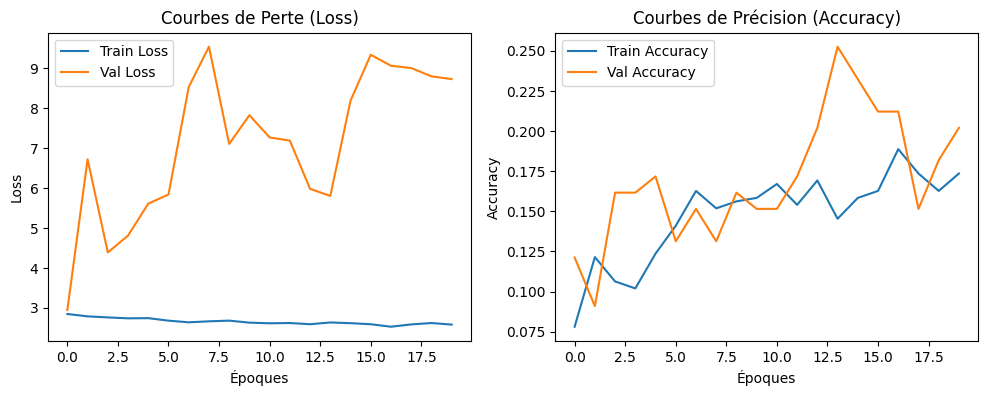

In [29]:
plot_history(history)

### 4. Évaluation

#### Question 4.a

On évalue les performanecs sur les jeux de train et de test :

In [35]:
# Évaluation sur le jeu d'entraînement
print("Performances sur le jeu d'entraînement (Train) :")
train_loss, train_acc = model_mlp.evaluate(X_train_norm, y_train_cat, verbose=0)
print(f"Loss : {train_loss:.4f}")
print(f"Accuracy : {train_acc:.4f} ({train_acc:.2%})")

# Évaluation sur le jeu de test (Test)
print("\nPerformances sur le jeu de test (Test) :")
test_loss, test_acc = model_mlp.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Loss : {test_loss:.4f}")
print(f"Accuracy : {test_acc:.4f} ({test_acc:.2%})")

Performances sur le jeu d'entraînement (Train) :
Loss : 7.8748
Accuracy : 0.1952 (19.52%)

Performances sur le jeu de test (Test) :
Loss : 8.0574
Accuracy : 0.1515 (15.15%)


#### Question 4.b

On récupère les prédictions sur le jeu de test :

In [38]:
y_pred_prob = model_mlp.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Les vrais labels (y_test_cat) sont en one-hot, on les repasse en entiers
y_true = np.argmax(y_test_cat, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


On calcule la matrice de confusion :

In [39]:
cm = confusion_matrix(y_true, y_pred_classes)

On affiche la matrice de confusion :

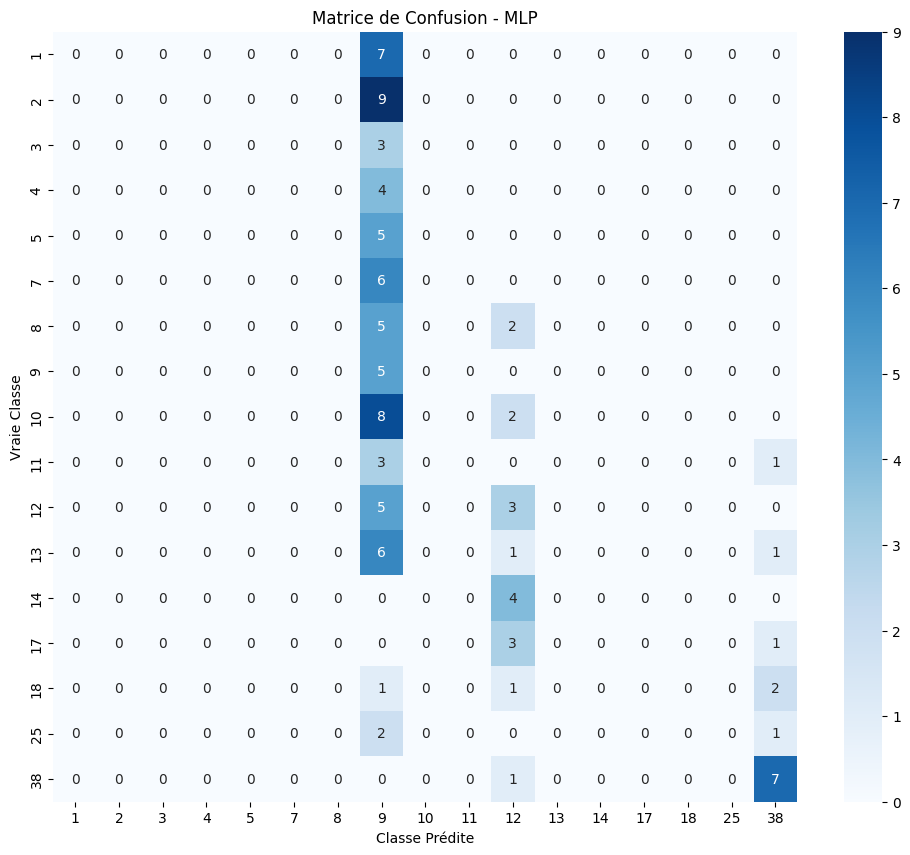

In [40]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, # Affiche les vrais IDs des classes
            yticklabels=le.classes_)
plt.title('Matrice de Confusion - MLP')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

Voici le rapport de classification :

In [43]:
print(classification_report(y_true, y_pred_classes, target_names=[str(c) for c in le.classes_], zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         7
           9       0.07      1.00      0.14         5
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         4
          12       0.18      0.38      0.24         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         4
          18       0.00      0.00      0.00         4
          25       0.00      0.00      0.00         3
          38       0.54      0.88      0.67         8

    accuracy              

#### Question 4.c

En observant la matrice de confusion et le rapport de classification, nous constatons que le modèle n'a pas réussi à généraliser. En effet, le modèle semble s'effondrer en prédisant majoritairement quelques classes spécifiques (notamment les classes 9, 12 et 38) tout en ignorant complètement les autres. Par exemple, la classe 38 a un rappel de 88%, mais une précision faible (54%), ce qui signifie que le modèle prédit cette classe très souvent, même quand c'est faux. La classe 9 a un rappel de 100% mais une précision de 7%, ce qui indique que le modèle prédit la classe 9 pour presque n'importe quelle image difficile. La plupart des autres classes (1, 2, 3, 4, 5, etc.) ont une précision et un rappel de 0% : le MLP n'a pas réussi à trouver de caractéristiques distinctives pour ces panneaux.

Les performances médiocres (~15% d'accuracy) s'expliquent par les limitations structurelles des MLP pour le traitement d'images. Tout d'abord, l'étape d'aplatissement en entrée détruit la structure 2D de l'image. Le réseau traite les pixels comme une suite de nombres indépendants sans comprendre que le pixel (i,j) est voisin du pixel (i,j+1). Il perd donc la notion de formes (cercle, triangle) essentielle aux panneaux. De plus, si un panneau est décalé de quelques pixels vers la gauche dans l'image, le vecteur d'entrée change complètement. Le MLP doit réapprendre à reconnaître le panneau pour chaque position possible, ce qui demande énormément de données que nous n'avons pas ici. Enfin, comme noté dans la partie 1, le dataset contient des variations de luminosité et des arrière-plans complexes. Le MLP, qui connecte chaque pixel d'entrée à chaque neurone caché, est très sensible à ce bruit de fond (clutter), contrairement aux CNN qui filtrent l'information locale.

Pour conclure, le MLP n'est pas adapté à cette tâche complexe. Pour améliorer les résultats, il est nécessaire d'utiliser des CNN, car ces derniers sont capables d'extraire des caractéristiques visuelles locales et invariants aux translations.

## Partie 3 - Classification avec couches CNN

### 1. Préparation des données

#### Question 1.a

#### Question 1.b

#### Question 1.c

### 2. Conception d’un réseau avec couches CNN

### 3. Entraînement

### 4. Évaluation

## Partie 4 - Transfert de connaissances (Transfer Learning)

### 1. Mise en place du transfert de connaissances

### 2. Entraînement du modèle pré-entraîné

### 3. Comparaison des performances

## Partie 5 - Localisation

### 1. Génération des données

### 2. Apprentissage et test du réseau

### 3. Extension du scénario

## Partie 6 - Synthèse et comparaison globale